# Setup

In [41]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from copy import deepcopy
from torch import nn
from cifar10_utils import get_cifar10, get_dataloader
from tqdm import tqdm

In [17]:
# Seed for reproduceability
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# Setup device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Backbone Architecture

We will use ResNet50 as our backbone architecture. The code is taken from [this GitHub repository by Maciej Balawejder](https://github.com/maciejbalawejder/Deep-Learning-Collection/tree/main/ConvNets/ResNet).

In [18]:
# ConvBlock
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()
        self.c = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        return self.bn(self.c(x))

# Bottleneck ResidualBlock 
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, first=False):
        super().__init__()
        res_channels = in_channels // 4
        stride = 1

        self.projection = in_channels!=out_channels
        if self.projection:
            self.p = ConvBlock(in_channels, out_channels, 1, 2, 0)
            stride = 2
            res_channels = in_channels // 2

        if first:
            self.p = ConvBlock(in_channels, out_channels, 1, 1, 0)
            stride = 1
            res_channels = in_channels


        self.c1 = ConvBlock(in_channels, res_channels, 1, 1, 0) 
        self.c2 = ConvBlock(res_channels, res_channels, 3, stride, 1)
        self.c3 = ConvBlock(res_channels, out_channels, 1, 1, 0)
        self.relu = nn.ReLU()

    def forward(self, x):
        f = self.relu(self.c1(x))
        f = self.relu(self.c2(f))
        f = self.c3(f)

        if self.projection:
            x = self.p(x)

        h = self.relu(torch.add(f, x))
        return h

# ResNetx
class ResNet(nn.Module):
    def __init__(
        self, 
        config_name : int, 
        in_channels=3, 
        classes=10
        ):
        super().__init__()

        configurations = {
            50 : [3, 4, 6, 3],
            101 : [3, 4, 23, 3],
            152 : [3, 8, 36, 3]
        }

        no_blocks = configurations[config_name]

        out_features = [256, 512, 1024, 2048]
        self.blocks = nn.ModuleList([ResidualBlock(64, 256, True)])

        for i in range(len(out_features)):
            if i > 0:
                self.blocks.append(ResidualBlock(out_features[i-1], out_features[i]))
            for _ in range(no_blocks[i]-1):
                self.blocks.append(ResidualBlock(out_features[i], out_features[i]))
        
        self.conv1 = ConvBlock(in_channels, 64, 7, 2, 3)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(2048, classes)

        self.relu = nn.ReLU()

        self.init_weight()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        for block in self.blocks:
            x = block(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

    def init_weight(self):
        for layer in self.modules():
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight)

In [19]:
# Loading the dataset
cifar10 = get_cifar10()
cifar10_loader = get_dataloader(cifar10, batch_size=128,return_numpy=False)

Files already downloaded and verified
Files already downloaded and verified


In [31]:
def evaluate_model(model, data_loader):
    """
    Performs the evaluation of the MLP model on a given dataset.

    Args:
      model: An instance of 'MLP', the model to evaluate.
      data_loader: The data loader of the dataset to evaluate.
    Returns:
        accuracy
    """
    accuracies_per_batch, losses_per_batch = [], []
    loss_module = nn.CrossEntropyLoss()
    # Get accuracy for epoch
    for batch in data_loader:
        
        # Get validation images and labels
        X = batch[0].to(device)
        y = batch[1].to(device)
        
        # Get predictions on validation set
        model.eval()
        with torch.no_grad():
            pred_logits = model.forward(X)
            pred_classes = torch.argmax(torch.softmax(pred_logits, dim=1), axis=1)
        
        # Calculate accuracy := # of correct preds / total # of preds
        current_accuracy = torch.sum(pred_classes == y) / pred_classes.shape[0]
        accuracies_per_batch.append(current_accuracy.item())
        current_loss = loss_module(pred_logits, y).item()
        losses_per_batch.append(current_loss)

    accuracy = np.average(accuracies_per_batch)
    loss = np.average(losses_per_batch)

    return accuracy, loss

In [38]:
def train(model, epochs=10, lr=0.01, momentum=0, verbose=True):
    
    logging_dict = {'loss': {'train': [], 'validation': []},
                    'accuracy': {'train': [], 'validation': []},
                    'lr': [],
                    'batches_per_epoch': [],}
    
    for epoch in tqdm(range(epochs)):
        
        batches_per_epoch = 0
        
        model.train()
        
        # Loss module and optimizer
        loss_module = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
        
         
        for batch in cifar10_loader['train']:
                        
            batches_per_epoch += 1
            
            # Get training images and labels
            X_train = batch[0].to(device)
            y_train = batch[1].to(device)
            
            # Forward pass
            train_pred_logits = model.forward(X_train)
            
            # Calculate loss
            loss = loss_module(train_pred_logits, y_train)
            logging_dict['loss']['train'].append(loss.item())
            
            # Calculate accuracy
            train_pred_class = torch.argmax(torch.softmax(train_pred_logits, dim=1), axis=1)
            train_accuracy = torch.sum(train_pred_class == y_train) / train_pred_class.shape[0]
            logging_dict['accuracy']['train'].append(train_accuracy.item())
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Backward pass
            loss.backward()
            
            # Update parameters
            optimizer.step()

        
        # Log num of batches for this epoch
        logging_dict['batches_per_epoch'].append(batches_per_epoch)
        
        # Log current LR
        logging_dict['lr'].append(optimizer.param_groups[0]['lr'])
        
        # Update LR
        scheduler.step(loss)
        
        # Get metrics on validation set
        validation_accuracy, validation_loss = evaluate_model(model, cifar10_loader['validation'])
        logging_dict['accuracy']['validation'].append(validation_accuracy.item())
        logging_dict['loss']['validation'].append(validation_loss.item())
        
        # Determine if best model
        if len(logging_dict['accuracy']['validation']) == 1 or \
            all([validation_accuracy > acc for acc in logging_dict['accuracy']['validation']]):
            best_model = deepcopy(model)
   
        if verbose:
            print(f'\n{epoch = }, '
                  f'training accuracy: {train_accuracy.item():.3f}, '
                  f'training loss: {loss.item():.3f}',
                  f'validation accuracy: {validation_accuracy.item():.3f}, '
                  f'validation loss: {validation_loss.item():.3f}',
                 )
    
    # Get metrics on test set
    test_accuracy, test_loss = evaluate_model(best_model, cifar10_loader['test'])
    
    return best_model, test_accuracy, test_loss, logging_dict

# Vanilla ResNet

In [43]:
resnet50 = ResNet(50).to(device)
resnet_best_model, resnet_test_acc, resnet_test_loss, resnet_logging_dict = train(resnet50)

 10%|█         | 1/10 [00:36<05:30, 36.67s/it]


epoch = 0, training accuracy: 0.273, training loss: 2.405 validation accuracy: 0.350, validation loss: 2.009


 20%|██        | 2/10 [01:12<04:49, 36.14s/it]


epoch = 1, training accuracy: 0.406, training loss: 1.839 validation accuracy: 0.407, validation loss: 1.811


 30%|███       | 3/10 [01:48<04:11, 35.92s/it]


epoch = 2, training accuracy: 0.484, training loss: 1.485 validation accuracy: 0.448, validation loss: 1.654


 40%|████      | 4/10 [02:24<03:35, 35.92s/it]


epoch = 3, training accuracy: 0.539, training loss: 1.476 validation accuracy: 0.471, validation loss: 1.545


 50%|█████     | 5/10 [02:59<02:59, 35.80s/it]


epoch = 4, training accuracy: 0.578, training loss: 1.269 validation accuracy: 0.489, validation loss: 1.527


 60%|██████    | 6/10 [03:35<02:23, 35.77s/it]


epoch = 5, training accuracy: 0.562, training loss: 1.338 validation accuracy: 0.474, validation loss: 1.636


 70%|███████   | 7/10 [04:10<01:47, 35.72s/it]


epoch = 6, training accuracy: 0.547, training loss: 1.367 validation accuracy: 0.492, validation loss: 1.573


 80%|████████  | 8/10 [04:46<01:11, 35.81s/it]


epoch = 7, training accuracy: 0.555, training loss: 1.275 validation accuracy: 0.519, validation loss: 1.509


 90%|█████████ | 9/10 [05:22<00:35, 35.83s/it]


epoch = 8, training accuracy: 0.664, training loss: 1.003 validation accuracy: 0.506, validation loss: 1.537


100%|██████████| 10/10 [05:58<00:00, 35.84s/it]


epoch = 9, training accuracy: 0.648, training loss: 1.013 validation accuracy: 0.516, validation loss: 1.538


In [167]:
%mkdir -p models
torch.save(resnet_best_model, './models/resnet50.pt')

In [164]:
def make_plots(logging_dict, model_name, avg_train=True):
#     logging_dict = {'loss': {'train': [], 'validation': []},
#                 'accuracy': {'train': [], 'validation': []},
#                 'lr': [],
#                 'batches_per_epoch': [],}
    epoch_ends = np.cumsum(logging_dict['batches_per_epoch'])
    
    def get_avg_per_epoch(batch_data):
        result = [None,]
        for i in range(len(epoch_ends) - 1):
            result.append(np.average(batch_data[epoch_ends[i]:epoch_ends[i + 1]]))
        return result
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    metrics = ('loss', 'accuracy')
    for metric, ax in zip(metrics, axes.ravel()):
#         ax.plot(logging_dict[metric]['train'])
        if avg_train:
            ax.plot(get_avg_per_epoch(logging_dict[metric]['train']), '.-', label='training set')
            ax.plot(logging_dict[metric]['validation'], '.-', label='validation set')
            ax.set(title=metric, xlabel='epoch', xticks=np.arange(len(epoch_ends)))
        else:
            ax.plot(logging_dict[metric]['train'],'.-', label='training set')
            ax.plot(epoch_ends, logging_dict[metric]['validation'],'.-', label='validation set')
            ax.set(title=metric, xlabel='batch')
    
    handles, labels = ax.get_legend_handles_labels()
    plt.figlegend(handles=handles, labels=labels, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=2)
    plt.suptitle(model_name)
    plt.tight_layout()
    plt.show()

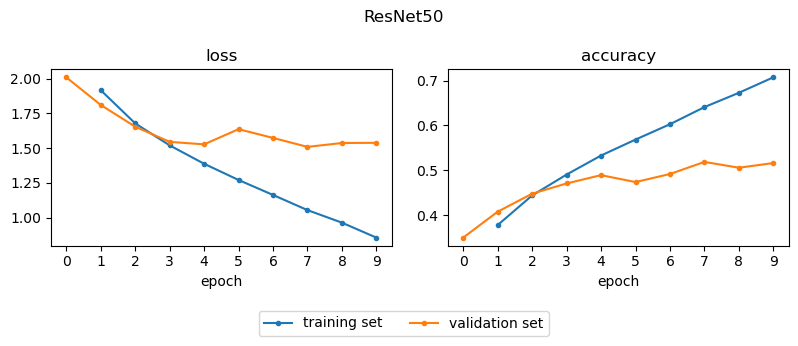

In [165]:
make_plots(resnet_logging_dict, 'ResNet50', avg_train=True)